# Fitting Transmission Parameters Diagnostic Output

In [1]:
from collections import namedtuple
import functools
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import pandas as pd
import re
import pneumodel as pn
from pneumodel.plotting import remove_spines, save_figure

/Users/ocsicnarf/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#### Set up plotting

In [2]:
%matplotlib inline
cubehelix = palettable.cubehelix.cubehelix1_16_r.mpl_colors
COLORS  = {'infant': cubehelix[6], 'toddler': cubehelix[10]}

#### Set up paths

In [3]:
OUTPUTS_PATH = "/Volumes/Samsung USB/TESTS"
FOLDER_NAME = "fit-transmission-longer-colonizations"
FIGURES_PATH = os.path.join(OUTPUTS_PATH, FOLDER_NAME, 'figures')
save_figure = functools.partial(pn.plotting.save_figure, folder=FIGURES_PATH, dpi=300)

#### Read in data

In [4]:
with open(os.path.join(OUTPUTS_PATH, FOLDER_NAME, 'configuration', 'configuration.json')) as f:
    CONFIG = json.load(f, object_hook=lambda d: namedtuple('Config', d.keys())(*d.values()))

In [5]:
print CONFIG.host

Config(sigma_sg=0.0, epsilon=0.1, sigmas_file=u'sigmas_kenya.json', halflife_st=-1, mu=0.25, halflife_sg=-1)


In [6]:
print CONFIG.simulation.num_initial_hosts
NUM_HOSTS = CONFIG.simulation.num_initial_hosts

20000


In [7]:
def csv2array(filename, max_len=None):
  path = os.path.join(OUTPUTS_PATH, FOLDER_NAME, 'trial-0', filename)
  return np.array(pd.read_csv(path, header=None))[:max_len]

In [16]:
MAX_ITERS = 200 #125

In [17]:
ERRORS    = csv2array('prevalence_errors.csv', MAX_ITERS)
LLHS      = csv2array('loglikelihood.csv', MAX_ITERS)
BETAS     = csv2array('beta.csv', MAX_ITERS).flatten()
RANKS     = csv2array('ranks.csv', MAX_ITERS)
PREVS_HAT = csv2array('estimated_prevalences.csv', MAX_ITERS)
PREVS     = csv2array('target_prevalences.csv', MAX_ITERS)[0]

In [18]:
ST_NAMES = np.array(pd.read_json(os.path.join(OUTPUTS_PATH, FOLDER_NAME, 'configuration/', CONFIG.serotype.serotypes_file))).flatten()
NUM_ST    = PREVS_HAT.shape[1] - 1 # subtract one for the prevalence of the "uncolonized"
NUM_ITERS = PREVS_HAT.shape[0]

In [19]:
def moving_average(array, n):
    S = np.cumsum(array, dtype=float)
    S[n:] = (S[n:] - S[:-n]) / n        # average most recent n elements
    S[:n] = S[:n] / np.arange(1, n + 1) # average available elements for the first n windows
    return S

### Figure

In [20]:
top_idx = PREVS.argsort()[::-1][1:] # remove the uncolonized
top_idx

array([22, 47, 48, 29,  4,  9, 41, 28,  1, 11, 19, 55,  8, 10, 12, 39, 34,
       14, 17, 20, 49, 23, 27, 24, 40,  0, 36, 44, 43, 42,  3, 38, 30,  7,
        2, 15, 32, 33, 18, 25, 26, 53,  6, 51, 13, 50, 46, 21, 37, 35,  5,
       31, 45, 52, 54, 16])

In [21]:
r = 24
i = top_idx[r]
print '{}-th most prevalent serotype: {} at {:.2f}%'.format(r, ST_NAMES[i], 100 * PREVS[i])
print 'its prevalence in the last 10 iterations:'
for p in PREVS_HAT[-10:, i]:
  print '{:.2f}%, '.format(p * 100),
print '...'

24-th most prevalent serotype: 35A at 0.53%
its prevalence in the last 10 iterations:
0.85%,  0.71%,  0.81%,  0.73%,  0.20%,  0.35%,  0.57%,  0.03%,  0.51%,  0.57%,  ...


In [25]:
n_plot = (PREVS[:-1] > 0.000).sum()

['/Volumes/Samsung USB/TESTS/fit-transmission-longer-colonizations/figures/parameter-estimation-st-6A-window-5-5.pdf',
 '/Volumes/Samsung USB/TESTS/fit-transmission-longer-colonizations/figures/parameter-estimation-st-6A-window-5-5.png']

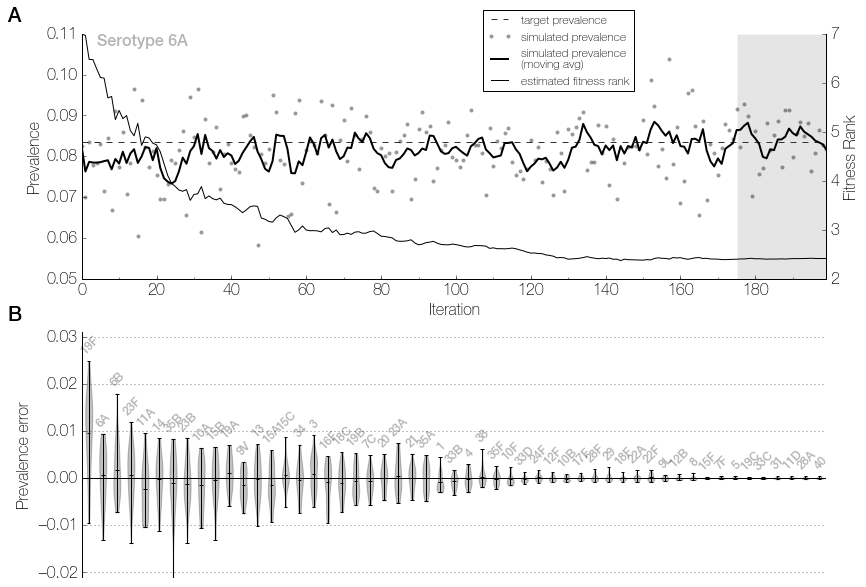

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

ax = axes[0]
a = 175 #100
b = 200 #125
r = 1
i = top_idx[r]
w = 5

### Panel A: parameter estimation for one serotype ###

# plot simulated prevalences
ys = PREVS_HAT[:, i]

ax.axhline(y=PREVS[i], ls='--', lw=1, c='.2', label='target prevalence')
ax.plot(ys, ls='None', marker='o', markersize=4, alpha=0.4, label='simulated prevalence')
ax.plot(moving_average(ys, n=w), lw=2, label='simulated prevalence\n(moving avg)')
ax.plot([], label='estimated fitness rank') # proxy for legend

ax.axvspan(a, b - 1, alpha=0.1)

ax.text(0.02, 1.0, 'Serotype {}'.format(ST_NAMES[i]), 
        ha='left', va='top', fontsize=16, alpha=0.3, weight='medium', transform=ax.transAxes)

lgd = ax.legend(fontsize=12, frameon=True, bbox_to_anchor=(0.75, 1.12))

ax.set_ylabel('Prevalence')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))

ax.set_xlabel('Iteration')

remove_spines(ax, left=True)


# plot rank
ax = ax.twinx()
ax.plot(RANKS[:, i])

ax.set_xlim(0, MAX_ITERS - 1)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax.set_ylabel('Fitness Rank')
remove_spines(ax, right=True)

### Panel B: Errors for top N serotypes ###
ax = axes[1]

for x, s in enumerate(top_idx[:n_plot]): 
  ys = PREVS_HAT[a:b, s] - PREVS[s]
  v = ax.violinplot(ys, [x], showmeans=True, showmedians=False, showextrema=True)
  pn.plotting.style_violin(v, '.2', 'k')
  ax.text(x + 0.1, max(ys) + 0.001, ST_NAMES[s], 
          ha='center', va='bottom', rotation=45, fontsize=12, weight='medium', alpha=0.3)

ax.axhline(y=0, c= 'k')

ax.set_xlabel('Serotype')
ax.set_xlim(-0.5, n_plot - 0.5)


ax.set_ylabel('Prevalence error')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
#ax.yaxis.set_ticks([-0.005, 0.005], minor=True)
ax.yaxis.grid(which='both')
ax.set_ylim(-0.021, 0.031)

remove_spines(ax, bottom=False)
ax.xaxis.set_visible(False)


### Add Panel Labels ###
panel_labels = []
for label, ax in zip('AB', axes):
  t = ax.text(-0.1, 1.05, label, fontsize=20, 
              fontweight='medium', transform=ax.transAxes)
  panel_labels.append(t)

fig.tight_layout()
save_figure(fig, 'parameter-estimation-st-{}-window-{}'.format(ST_NAMES[i], w), bbox_inches='tight', bbox_extra_artist=[panel_labels] + [lgd])